# ✅ Strategy Overview: Training 4 Models + Ensemble

---

## 🧩 Step 1: Train a CNN on Each Dataset Individually

We already have:

- `labels_avenue_train.csv` → **CNN_A**
- `labels_ped1_train.csv` → **CNN_P1**
- `labels_ped2_train.csv` → **CNN_P2**
- `labels_violent_train.csv` → **CNN_VF**

Each CNN:

- Trained from scratch using the **same 7-layer CNN architecture**.
- Uses only its own dataset’s images and labels.
- Saved after training:
  - `cnn_avenue.pth`
  - `cnn_ped1.pth`
  - `cnn_ped2.pth`
  - `cnn_violent.pth`

---


## 🧬 Step 2: Combine the Models into an Ensemble

### 🔹 Our solution: Ensemble Voting (Fast & Simple)

- Input test frame into all 4 models.
- Get predictions like: `[0, 1, 0, 1]`
- Apply **majority voting** or **average the probabilities** for the final decision.

## 🧠 Why This Works

- Each dataset has its **own distribution**.
- A model trained only on **Avenue** might struggle on **Violent-Flows**.
- **Dataset-specific training** ensures deep understanding per domain.
- The ensemble approach allows **generalization** across datasets — **without retraining on 12k frames**.


### 📁 CNN_A: Training on Avenue Dataset
We begin by training a CNN using the Avenue dataset. The model is based on our 7-layer architecture:

1. Input: 200×200 grayscale
2. Conv(64, 3×3) + ReLU + MaxPooling(2×2)
3. Conv(64, 3×3) + ReLU + MaxPooling(2×2)
4. Flatten
5. FC + ReLU
6. FC + Sigmoid
7. Output: Binary (0=Normal, 1=Abnormal)

Dataset: `labels_avenue_train.csv`


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
from torchvision import transforms
import os

# Custom dataset
class FrameDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((200, 200)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        image = Image.open(img_path)
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# Dataset & loader
avenue_dataset = FrameDataset('combined_data/avenue/train.csv')
avenue_loader = DataLoader(avenue_dataset, batch_size=32, shuffle=True)


### 🧠 CNN Architecture Definition
This CNN model has the following layers:

1. Conv Block 1: Conv2d → ReLU → MaxPool
2. Conv Block 2: Conv2d → ReLU → MaxPool
3. Flatten
4. FC Layer 1: Linear → ReLU
5. FC Layer 2: Linear → Sigmoid (for binary classification)


In [2]:
class CNN_Avenue(nn.Module):
    def __init__(self):
        super(CNN_Avenue, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 50 * 50, 128),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x.squeeze()


### 🎯 Model Training Setup
We define the training loop using:

- **Loss Function**: Binary Cross Entropy (BCE)
- **Optimizer**: Adam
- **Epochs**: Typically 5–20 depending on dataset size
- **Metrics**: We'll track loss and (optionally) accuracy
After training, we save the model as `cnn_avenue.pth`.


In [3]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN_Avenue().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []

    loop = tqdm(avenue_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predictions and labels for metrics
        preds = (outputs > 0.5).float()  # Threshold for binary classification
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Live display of loss and accuracy
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        loop.set_postfix(loss=loss.item(), acc=batch_acc)

    # Compute metrics for the epoch
    epoch_loss = total_loss / len(avenue_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Print metrics
    print(f"📅 Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"   🔻 Loss:     {epoch_loss:.4f}")
    print(f"   ✅ Accuracy: {epoch_acc:.4f}")
    print(f"   🎯 Precision:{epoch_precision:.4f}")
    print(f"   🔁 Recall:   {epoch_recall:.4f}")
    print(f"   🧠 F1 Score: {epoch_f1:.4f}")
    print("--------------------------------------------------")

📅 Epoch 1/10 Summary:
   🔻 Loss:     0.5801
   ✅ Accuracy: 0.6676
   🎯 Precision:0.6490
   🔁 Recall:   0.6343
   🧠 F1 Score: 0.6415
--------------------------------------------------


📅 Epoch 2/10 Summary:
   🔻 Loss:     0.3310
   ✅ Accuracy: 0.8481
   🎯 Precision:0.8155
   🔁 Recall:   0.8740
   🧠 F1 Score: 0.8437
--------------------------------------------------


📅 Epoch 3/10 Summary:
   🔻 Loss:     0.2208
   ✅ Accuracy: 0.9087
   🎯 Precision:0.8766
   🔁 Recall:   0.9373
   🧠 F1 Score: 0.9059
--------------------------------------------------


📅 Epoch 4/10 Summary:
   🔻 Loss:     0.1455
   ✅ Accuracy: 0.9444
   🎯 Precision:0.9189
   🔁 Recall:   0.9668
   🧠 F1 Score: 0.9422
--------------------------------------------------


📅 Epoch 5/10 Summary:
   🔻 Loss:     0.1159
   ✅ Accuracy: 0.9592
   🎯 Precision:0.9415
   🔁 Recall:   0.9736
   🧠 F1 Score: 0.9573
--------------------------------------------------


📅 Epoch 6/10 Summary:
   🔻 Loss:     0.0900
   ✅ Accuracy: 0.9688
   🎯 Precision:0.9541
   🔁 Recall:   0.9808
   🧠 F1 Score: 0.9672
--------------------------------------------------


📅 Epoch 7/10 Summary:
   🔻 Loss:     0.0656
   ✅ Accuracy: 0.9790
   🎯 Precision:0.9689
   🔁 Recall:   0.9870
   🧠 F1 Score: 0.9779
--------------------------------------------------


📅 Epoch 8/10 Summary:
   🔻 Loss:     0.0588
   ✅ Accuracy: 0.9806
   🎯 Precision:0.9725
   🔁 Recall:   0.9867
   🧠 F1 Score: 0.9795
--------------------------------------------------


📅 Epoch 9/10 Summary:
   🔻 Loss:     0.0421
   ✅ Accuracy: 0.9875
   🎯 Precision:0.9807
   🔁 Recall:   0.9929
   🧠 F1 Score: 0.9867
--------------------------------------------------


📅 Epoch 10/10 Summary:
   🔻 Loss:     0.0323
   ✅ Accuracy: 0.9905
   🎯 Precision:0.9876
   🔁 Recall:   0.9922
   🧠 F1 Score: 0.9899
--------------------------------------------------


### ✅ Save the Trained CNN_Avenue Model
After training completes, we save the model weights for later use in ensemble or evaluation.


In [4]:
torch.save(model.state_dict(), "models/cnn_avenue.pth")
print("✅ Model saved to cnn_avenue.pth")

✅ Model saved to cnn_avenue.pth


📊 Step 5: Evaluation on Test Set using ROC, AUC, and EER
We will:

Load the saved model (cnn_avenue.pth)

Run inference on a labeled test set (labels_avenue_test.csv)

Calculate TPR, FPR, and plot ROC curve

Compute AUC and EER

Loading model + custom data loader

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN_Avenue().to(device)
model.load_state_dict(torch.load("models/cnn_avenue.pth", map_location=device))
model.eval()

# Custom Dataset for test data (grayscale + resize 200x200)
class AvenueTestDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((200, 200)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        img = Image.open(img_path).convert('L')  # grayscale
        if self.transform:
            img = self.transform(img)
        return img, label

# Load test dataset & dataloader
test_dataset = AvenueTestDataset('combined_data/avenue/test.csv')  # or your test csv path
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




Computing test factors ; 

In [47]:
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate ROC, AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

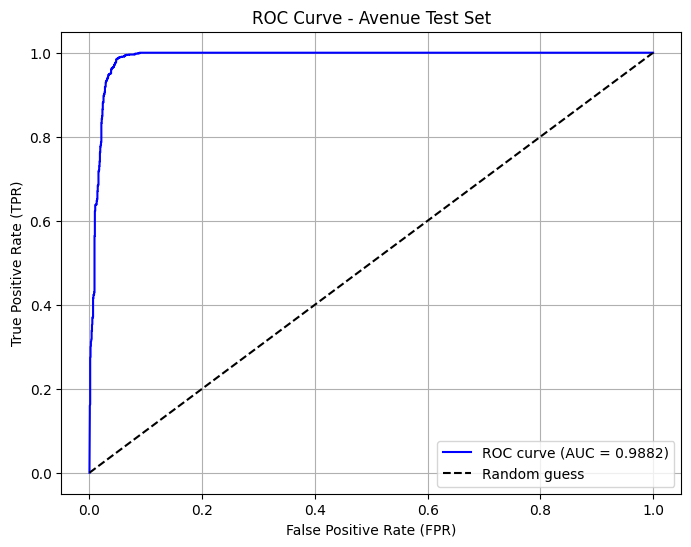

In [48]:

from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 1. ROC Curve & AUC
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Avenue Test Set')
plt.legend(loc='lower right')
plt.grid()
plt.show()


EER: 0.0390 at threshold 0.6718
Average Precision (AP): 0.9805


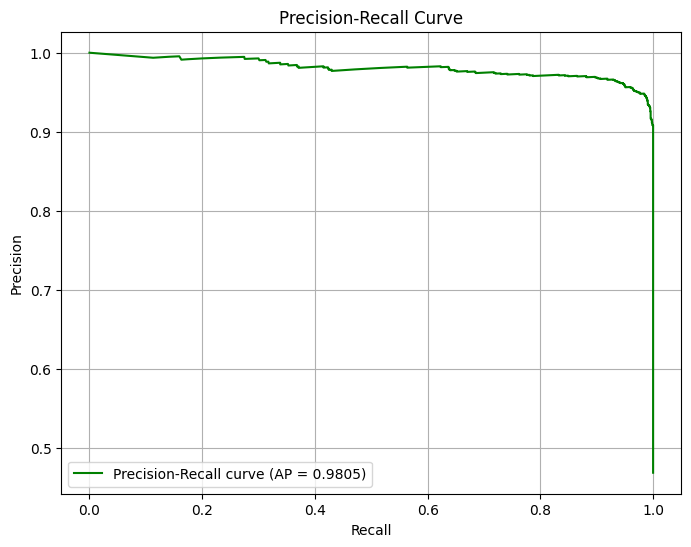

In [49]:
# Compute Equal Error Rate (EER)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"EER: {eer:.4f} at threshold {eer_threshold:.4f}")

# 2. Precision-Recall Curve & Average Precision
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs)
from sklearn.metrics import average_precision_score
avg_precision = average_precision_score(all_labels, all_probs)
print(f"Average Precision (AP): {avg_precision:.4f}")

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

EER: 0.0390 at threshold 0.6718


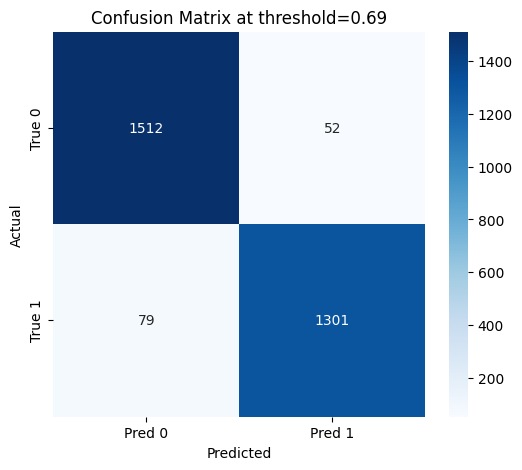

At threshold=0.69:
Accuracy:  0.9555
Precision: 0.9616
Recall:    0.9428
F1 Score:  0.9521


In [50]:
# 3. Compute EER and threshold
fnr = 1 - tpr
eer_idx = np.nanargmin(np.absolute((fnr - fpr)))
eer_threshold = roc_thresholds[eer_idx]
eer = fpr[eer_idx]
print(f"EER: {eer:.4f} at threshold {eer_threshold:.4f}")

# 4. Choose threshold (can use 0.5 or EER threshold)
threshold = 0.69  # or eer_threshold

# 5. Binary predictions at chosen threshold
preds = (all_probs >= threshold).astype(int)

# 6. Confusion matrix
cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title(f'Confusion Matrix at threshold={threshold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7. Accuracy, Precision, Recall, F1 Score
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds, zero_division=0)
rec = recall_score(all_labels, preds, zero_division=0)
f1 = f1_score(all_labels, preds, zero_division=0)

print(f"At threshold={threshold}:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

🧪 Step 1: Train CNN on UCSD Ped1 Dataset (CNN_P1)
We'll follow the same process:

Define dataset loader

Define CNN model (same architecture)

Train the model

Save the model: cnn_ped1.pth

Evaluate using ROC, AUC, and EER



In [8]:
class FrameDatasetPed1(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((200, 200)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        image = Image.open(img_path)
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# Load training data
train_dataset_ped1 = FrameDatasetPed1("data/UCSD_Anomaly_Dataset.v1p2/labels_ped1_train.csv")
train_loader_ped1 = DataLoader(train_dataset_ped1, batch_size=32, shuffle=True)


🧱 Step 2: Use same CNN model

In [9]:
model = CNN_Avenue().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

🧱 Step 3: Training Loop

In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Wrap the train_loader with tqdm for progress bar
    loop = tqdm(train_loader_ped1, desc=f"📅 Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update tqdm description dynamically
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1}/{num_epochs} - 🔻 Avg Loss: {total_loss / len(train_loader_ped1):.4f}")


✅ Epoch 1/10 - 🔻 Avg Loss: 0.0030


✅ Epoch 2/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 3/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 4/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 5/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 6/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 7/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 8/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 9/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 10/10 - 🔻 Avg Loss: 0.0000


✅ Step 4: Save Trained Model

In [ ]:
torch.save(model.state_dict(), "models/cnn_ped1.pth")
print("✅ Model saved to cnn_ped1.pth")


Step 1: Train CNN on UCSD Ped2 Dataset (CNN_P2)
We’ll follow the same process:

📄 Dataset CSV: labels_ped2_train.csv

📦 Custom Dataset + DataLoader

🧱 Model: Same architecture (CNN_Avenue)

🎯 Training loop

💾 Save: cnn_ped2.pth

In [10]:
class FrameDatasetPed2(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((200, 200)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        image = Image.open(img_path)
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# Create DataLoader
train_dataset_ped2 = FrameDatasetPed2("data/UCSD_Anomaly_Dataset.v1p2/labels_ped2_train.csv")
train_loader_ped2 = DataLoader(train_dataset_ped2, batch_size=32, shuffle=True)


🧱 Step 2: CNN Model + Optimizer

In [11]:
model = CNN_Avenue().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


🧱 Step 3: Training Loop

In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # tqdm progress bar for each batch in the epoch
    loop = tqdm(train_loader_ped2, desc=f"📅 Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update progress bar with current batch loss
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1}/{num_epochs} - 🔻 Avg Loss: {total_loss / len(train_loader_ped2):.4f}")


✅ Epoch 1/10 - 🔻 Avg Loss: 0.0091


✅ Epoch 2/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 3/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 4/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 5/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 6/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 7/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 8/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 9/10 - 🔻 Avg Loss: 0.0000


✅ Epoch 10/10 - 🔻 Avg Loss: 0.0000


In [ ]:
torch.save(model.state_dict(), "models/cnn_ped2.pth")
print("✅ Model saved to cnn_ped2.pth")


Last one for vilolent flows


In [12]:
class FrameDatasetVF(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((200, 200)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label']
        image = Image.open(img_path)
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# Create DataLoader
train_dataset_vf = FrameDatasetVF("data/Violent-Flows/violentflows_labels.csv")
train_loader_vf = DataLoader(train_dataset_vf, batch_size=32, shuffle=True)


In [13]:
model = CNN_Avenue().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # tqdm progress bar for each batch in the epoch
    loop = tqdm(train_loader_vf, desc=f"📅 Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update progress bar with current batch loss
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1}/{num_epochs} - 🔻 Avg Loss: {total_loss / len(train_loader_vf):.4f}")


✅ Epoch 1/10 - 🔻 Avg Loss: 0.3294


✅ Epoch 2/10 - 🔻 Avg Loss: 0.0545


✅ Epoch 3/10 - 🔻 Avg Loss: 0.0186


✅ Epoch 4/10 - 🔻 Avg Loss: 0.0086


✅ Epoch 5/10 - 🔻 Avg Loss: 0.0037


✅ Epoch 6/10 - 🔻 Avg Loss: 0.0013


✅ Epoch 7/10 - 🔻 Avg Loss: 0.0009


✅ Epoch 8/10 - 🔻 Avg Loss: 0.0083


✅ Epoch 9/10 - 🔻 Avg Loss: 0.0038


✅ Epoch 10/10 - 🔻 Avg Loss: 0.0004


In [ ]:
torch.save(model.state_dict(), "models/cnn_VF.pth")
print("✅ Model saved to cnn_VF.pth")

🧱 Step 1: Load All Models
Assuming all models use the same architecture (CNN_Avenue) and are stored as:

models/cnn_avenue.pth

models/cnn_ped1.pth

models/cnn_ped2.pth

models/cnn_violent.pth

In [14]:
model_A = CNN_Avenue().to(device)
model_P1 = CNN_Avenue().to(device)
model_P2 = CNN_Avenue().to(device)
model_VF = CNN_Avenue().to(device)

model_A.load_state_dict(torch.load("models/cnn_avenue.pth", map_location=device))
model_P1.load_state_dict(torch.load("models/cnn_ped1.pth", map_location=device))
model_P2.load_state_dict(torch.load("models/cnn_ped2.pth", map_location=device))
model_VF.load_state_dict(torch.load("models/cnn_VF.pth", map_location=device))

models = [model_A, model_P1, model_P2, model_VF]

for m in models:
    m.eval()


🧱 Step 2: Frame Preprocessing Function

In [15]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

def preprocess_image(img_path):
    image = Image.open(img_path)
    image = transform(image)
    image = image.unsqueeze(0)
    return image.to(device)


🧱 Step 3: Voting Function

In [ ]:
def ensemble_predict(img_path, threshold=0.5):
    image = preprocess_image(img_path)
    outputs = []

    for model in models:
        with torch.no_grad():
            prob = model(image).item()
            prediction = 1 if prob >= threshold else 0
            outputs.append((prob, prediction))

  
    predictions = [pred for _, pred in outputs]
    final_vote = int(sum(predictions) >= 3)

    # Table display
    print(f"\n🧮 Voting Table for: {img_path}")
    print("Model\t\tProbability\tPrediction")
    print("----------------------------------------")
    names = ["CNN_A", "CNN_P1", "CNN_P2", "CNN_VF"]
    for name, (prob, pred) in zip(names, outputs):
        print(f"{name}\t\t{prob:.4f}\t\t{pred}")
    print("----------------------------------------")
    print(f"✅ Final Ensemble Prediction: {final_vote} (0=Normal, 1=Abnormal)")

    return final_vote


✅ Example Usage onone frame

In [17]:
frame_path = "data/Violent-Flows/frames/balcony_football_violence__Brannik_Football_Violence__Nattevandring__ysW-tGv-YjI/frame_0000.png"
ensemble_predict(frame_path)


🧮 Voting Table for: data/Violent-Flows/frames/balcony_football_violence__Brannik_Football_Violence__Nattevandring__ysW-tGv-YjI/frame_0000.png
Model		Probability	Prediction
----------------------------------------
CNN_A		0.0000		0
CNN_P1		0.0000		0
CNN_P2		0.0000		0
CNN_VF		1.0000		1
----------------------------------------
✅ Final Ensemble Prediction: 0 (0=Normal, 1=Abnormal)


0